# Step 1 - Preliminaries

## Imports and Configuration

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

import time

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

## Data Preprocessing

In [2]:
data_dir = Path("../input/house-prices-advanced-regression-techniques/")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")

In [3]:
# let's get be familiar to dataset
# There is a great distance between min. max. of SalePrice values 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


In [4]:
categorical_cols = [cname for cname in df.columns if
                                df[cname].dtype == "object"]

df[categorical_cols].nunique()

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

In [5]:
df.Exterior2nd.unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

<AxesSubplot:xlabel='GarageYrBlt', ylabel='Count'>

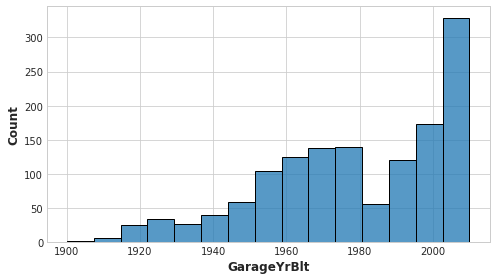

In [6]:
plt.figure(figsize=(7,4))
sns.histplot(df["GarageYrBlt"])

<AxesSubplot:xlabel='YearBuilt', ylabel='Count'>

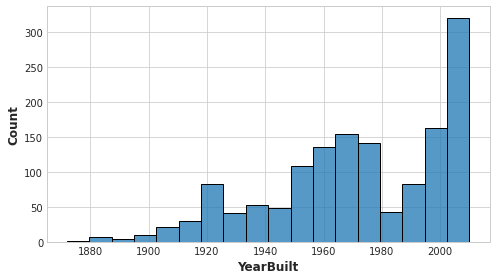

In [7]:
plt.figure(figsize=(7,4))
sns.histplot(df["YearBuilt"])

## Clean Data

In [8]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

## Encode the Statistical Data Type

In [9]:
# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", 
                "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
                "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
                "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


## Handle Missing Values

In [10]:
# Check the percentage of missing
columns_ = list(df.columns)
for col in columns_:
    if df[col].isnull().mean() != 0.0:
        print(f"{col}: {df[col].isnull().mean()}")
        print()

LotFrontage: 0.1773972602739726

Alley: 0.9376712328767123

MasVnrType: 0.005479452054794521

MasVnrArea: 0.005479452054794521

BsmtQual: 0.025342465753424658

BsmtCond: 0.025342465753424658

BsmtExposure: 0.026027397260273973

BsmtFinType1: 0.025342465753424658

BsmtFinType2: 0.026027397260273973

Electrical: 0.0006849315068493151

FireplaceQu: 0.4726027397260274

GarageType: 0.05547945205479452

GarageYrBlt: 0.05547945205479452

GarageFinish: 0.05547945205479452

GarageQual: 0.05547945205479452

GarageCond: 0.05547945205479452

PoolQC: 0.9952054794520548

Fence: 0.8075342465753425

MiscFeature: 0.963013698630137



In [11]:
def impute(df):
    for name in df.select_dtypes("number"):
        # df[name] = df[name].fillna(df[name].median())
        df[name] = df[name].fillna(0)
        
    for name in df.select_dtypes("category"):
        # df[name] = df[name].fillna(df[name].value_counts().idxmax())
        df[name] = df[name].fillna("None")
    return df

In [12]:
def load_data():
    # Read data
    data_dir = Path("../input/house-prices-advanced-regression-techniques/")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test

In [13]:
# Load Data

df_train, df_test = load_data()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [14]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000.0


<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

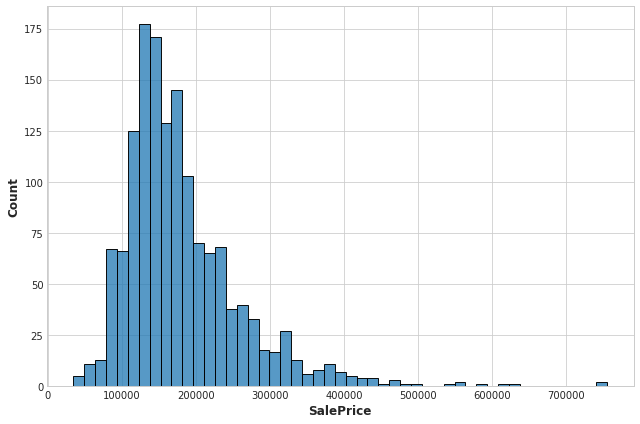

In [15]:
# SalesPrice label distrubition visualizing
plt.figure(figsize=(9,6))
sns.histplot(df_train["SalePrice"])

## Establish Baseline

In [16]:
def score_dataset(X, y, model=XGBRegressor()):
    
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    
    # Metric for RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [17]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_score = score_dataset(X, y)
print(f"Baseline score: {baseline_score:.5f} RMSLE")

Baseline score: 0.14351 RMSLE


# Step 2 - Feature Utility Scores

In [18]:

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [19]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual     0.571457
Neighborhood    0.526220
GrLivArea       0.430395
YearBuilt       0.407974
LotArea         0.394468
                  ...   
PoolQC          0.000000
MiscFeature     0.000000
MiscVal         0.000000
MoSold          0.000000
YrSold          0.000000
Name: MI Scores, Length: 79, dtype: float64

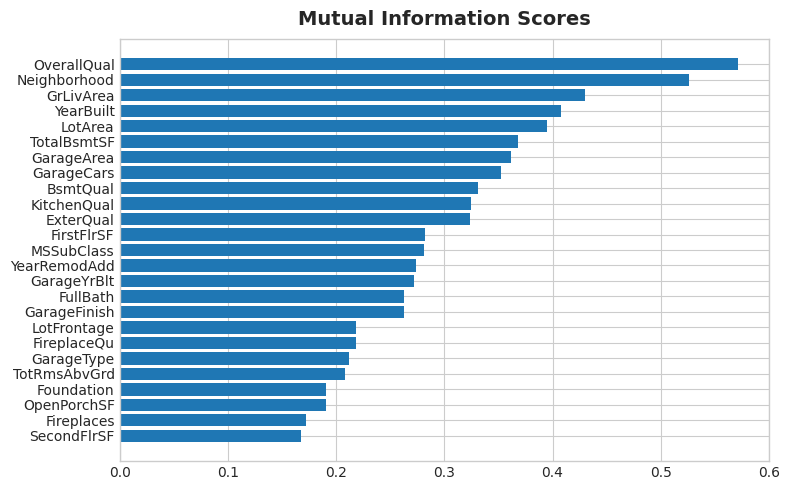

In [20]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(25))

In [21]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

In [22]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

0.14338026718687275

# Step 3 - Create Features

In [23]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

## Create Features with Pandas

In [24]:
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X


## k-Means Clustering

In [25]:
cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    
    kmeans = KMeans(n_clusters=10, n_init=50, random_state=0) # n_clusters=20
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd


## Principal Component Analysis

In [26]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


In [27]:
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

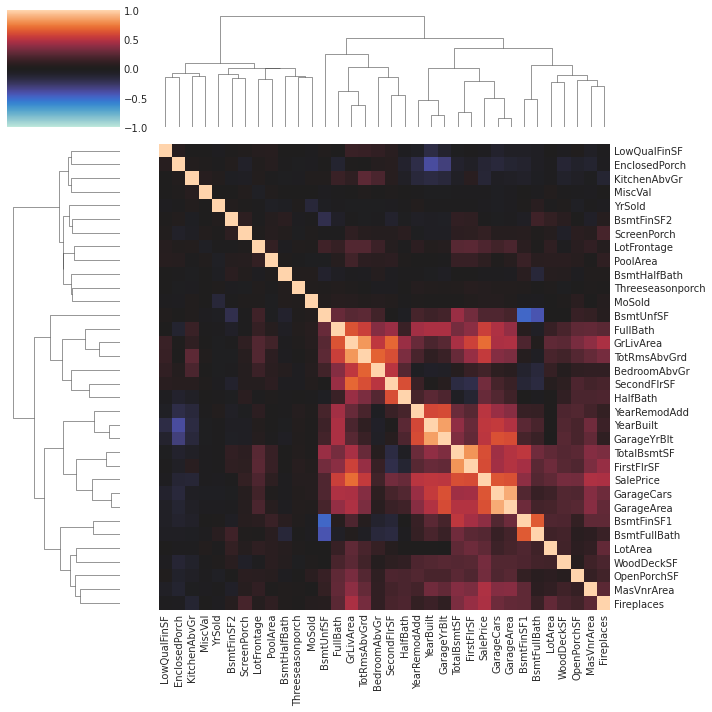

In [28]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)

## PCA Application - Indicate Outliers

In [29]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new

## Target Encoding

In [30]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the other
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

## Final Feature Set

In [31]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    # Mutual Information
    X = drop_uninformative(X, mi_scores)

    # Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    #  Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
 
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=10))

    # PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    # Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


0.13819256299696586

# Step 4 - Hyperparameter Tuning

In [32]:
def gridSearchCVFunc(X, y, model_, params_):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
        
    gs = GridSearchCV(estimator= model_,
                  param_grid = params_,
                  scoring =  'neg_root_mean_squared_error',
                  cv = 5)
    grid_search = gs.fit(X,y)
    return grid_search

In [33]:
def modelExec(X, y, model, params):
    st_process = time.process_time()
    st_wall = time.time()

    grid_search = gridSearchCVFunc(X, y, model, params)
    model = grid_search.best_estimator_
    print(grid_search.best_params_)

    score_ = score_dataset(X, y, model)

    et_process = time.process_time()
    res = et_process - st_process
    elapsed_time = time.time() - st_wall
    
    print('CPU Execution time:', res, 'seconds')
    print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    print(f"{score_}\n")

    return model


In [34]:
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]
X_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Bldg_2fmCon,Bldg_Duplex,Bldg_Twnhs,Bldg_TwnhsE,Bldg_None,PorchTypes,MedNhbdArea,Feature1,Feature2,MSSubClass_encoded
Id,,,,,,,,,,,,,,,,,,,,,
1,5,3,65.0,8450,1,2,1,3,3,4,...,0,0,0,0,0,1,1500.0,2566.0,1714568.0,239516.446215
2,0,3,80.0,9600,1,2,1,3,3,2,...,0,0,0,0,0,1,1437.0,2524.0,2493712.0,185723.883274
3,5,3,68.0,11250,1,2,2,3,3,4,...,0,0,0,0,0,1,1500.0,2706.0,1841840.0,239516.446215
4,6,3,60.0,9550,1,2,2,3,3,0,...,0,0,0,0,0,2,1717.0,2473.0,1489320.0,166639.379087
5,5,3,84.0,14260,1,2,2,3,3,2,...,0,0,0,0,0,2,2418.0,3343.0,2290000.0,239516.446215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,5,3,62.0,7917,1,2,1,3,3,4,...,0,0,0,0,0,1,1593.0,2600.0,1906000.0,240928.838526
1457,0,3,85.0,13175,1,2,1,3,3,4,...,0,0,0,0,0,1,1664.0,3615.0,3065496.0,183654.853847
1458,6,3,66.0,9042,1,2,1,3,3,4,...,0,0,0,0,0,1,1717.0,3492.0,2310912.0,164348.875596


In [35]:
print('GradientBoostingRegressor Params:')
gboosting_params = {'learning_rate': [.02, .03, .05], # 0.04
                  'subsample'    : [.1, .2, .5], # 0.1
                  'n_estimators' : [500, 800], # 1500, 1000
                  'max_depth'    : [6,8],
              "min_samples_split" : [10, 15]}
gboosting = GradientBoostingRegressor()
gboosting_model = modelExec(X_train, y_train, gboosting, gboosting_params)



print('XGBRegressor Params:')
xgb_params = dict(
    max_depth=[4, 6],           # maximum depth of each tree - try 2 to 10
    learning_rate=[0.01, 0.03],    # effect of each tree - try 0.0001 to 0.1
    n_estimators=[1500, 2000],     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=[3],    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=[0.7],  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=[0.5, 0.7],         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=[0.5],         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=[1.0],        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=[1],   # set > 1 for boosted random forests
)
xgb = XGBRegressor()
xgb_model = modelExec(X_train, y_train, xgb, xgb_params)



GradientBoostingRegressor Params:
{'learning_rate': 0.05, 'max_depth': 6, 'min_samples_split': 15, 'n_estimators': 500, 'subsample': 0.5}
CPU Execution time: 1048.476024582 seconds
Execution time: 00:17:32
0.12220283620562018

XGBRegressor Params:
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 1500, 'num_parallel_tree': 1, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.7}
CPU Execution time: 1149.44192898 seconds
Execution time: 00:09:59
0.11976640214439603



# Step 5 - Train Model and Create Submissions

In [36]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]


# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
gboosting_model.fit(X_train, np.log(y))
predictions = np.exp(gboosting_model.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('submission.csv', index=False)
print("Submission saved!")

Submission saved!
